# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-4vl_lhml
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-4vl_lhml
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


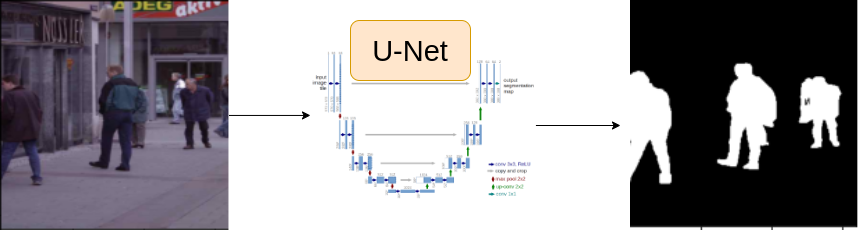

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'


DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.loc[4]

image_path = row.images 
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

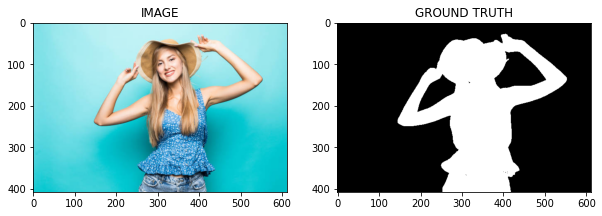

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as alb

In [ ]:
def get_train_augs():
  return alb.Compose([alb.Resize(IMG_SIZE, IMG_SIZE),
                      alb.HorizontalFlip(p = 0.5),
                      alb.VerticalFlip(p = 0.5)])
  
def get_valid_augs():
  return alb.Compose([alb.Resize(IMG_SIZE, IMG_SIZE)])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis = -1)


    if self.augmentations:
      data = self.augmentations(image= image, mask = mask)
      image = data['image']
      mask = data['mask']
    
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)


    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask



In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


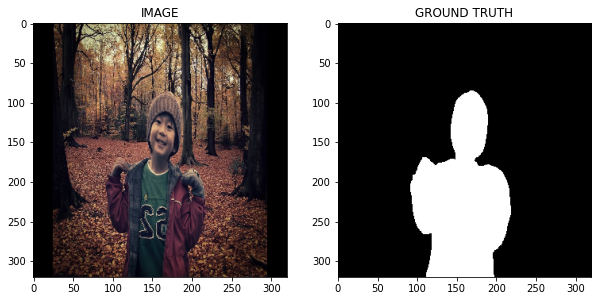

In [ ]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)


In [ ]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")


total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):


  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )


  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)

      return logits, loss1 + loss2

    return logits




In [ ]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0


  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()


    total_loss += loss.item()

  return total_loss/len(data_loader)

In [ ]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)


      total_loss += loss.item()


  return total_loss/len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED-MODEL")

    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


SAVED-MODEL
Epoch : 1 Train_loss : 0.701447872320811 Valid_loss : 1.9992820620536804


100%|██████████| 4/4 [00:01<00:00,  3.39it/s]


SAVED-MODEL
Epoch : 2 Train_loss : 0.3836230953534444 Valid_loss : 0.4238402247428894


100%|██████████| 4/4 [00:00<00:00,  4.64it/s]


Epoch : 3 Train_loss : 0.3452575792868932 Valid_loss : 0.4394165202975273


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


SAVED-MODEL
Epoch : 4 Train_loss : 0.31640299757321677 Valid_loss : 0.2686459459364414


100%|██████████| 4/4 [00:00<00:00,  4.69it/s]


SAVED-MODEL
Epoch : 5 Train_loss : 0.24478621383508045 Valid_loss : 0.2351824976503849


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Epoch : 6 Train_loss : 0.2105388472477595 Valid_loss : 0.25726810842752457


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


SAVED-MODEL
Epoch : 7 Train_loss : 0.194965660572052 Valid_loss : 0.21564332395792007


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch : 8 Train_loss : 0.18293401847283045 Valid_loss : 0.24695758521556854


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch : 9 Train_loss : 0.16490955551465353 Valid_loss : 0.24715587496757507


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


Epoch : 10 Train_loss : 0.17325093001127242 Valid_loss : 0.23911982029676437


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch : 11 Train_loss : 0.15645950337251027 Valid_loss : 0.22473632544279099


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 12 Train_loss : 0.14990117748578388 Valid_loss : 0.3018499091267586


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch : 13 Train_loss : 0.14815110117197036 Valid_loss : 0.25893137603998184


100%|██████████| 4/4 [00:00<00:00,  4.63it/s]


Epoch : 14 Train_loss : 0.16750794798135757 Valid_loss : 0.30458544567227364


100%|██████████| 4/4 [00:00<00:00,  4.47it/s]


SAVED-MODEL
Epoch : 15 Train_loss : 0.14989740947882335 Valid_loss : 0.19196072593331337


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch : 16 Train_loss : 0.12620814243952433 Valid_loss : 0.257261548191309


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


SAVED-MODEL
Epoch : 17 Train_loss : 0.11408865203460057 Valid_loss : 0.17923374101519585


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]


Epoch : 18 Train_loss : 0.13449918727080026 Valid_loss : 0.1813935749232769


100%|██████████| 4/4 [00:00<00:00,  4.66it/s]


Epoch : 19 Train_loss : 0.13923349877198538 Valid_loss : 0.18419302254915237


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch : 20 Train_loss : 0.14413179109493893 Valid_loss : 0.23328499868512154


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


Epoch : 21 Train_loss : 0.13885224560896556 Valid_loss : 0.23839585669338703


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch : 22 Train_loss : 0.18180669794480006 Valid_loss : 0.2100888341665268


100%|██████████| 4/4 [00:00<00:00,  4.72it/s]


Epoch : 23 Train_loss : 0.17715656161308288 Valid_loss : 0.21546637639403343


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch : 24 Train_loss : 0.1417049214243889 Valid_loss : 0.21902712434530258


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


SAVED-MODEL
Epoch : 25 Train_loss : 0.11686594535907109 Valid_loss : 0.1689405720680952


# Task 9 : Inference

In [ ]:
idx = 12

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

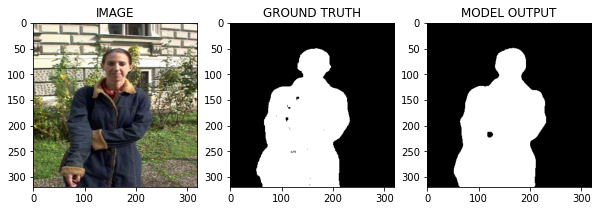

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya